In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft
from numpy.fft import rfft, irfft, rfftfreq

In [239]:
def load_light_amp_temp_function(light_amp, meta, classes, stim_duration=4, filter=False, sfreq = 296):
    trials = meta[1:,:2]
    times = meta[:,2]
    times = (times - times[0])[1:]
    # stim_end = int(stim_duration * sfreq + 0.75*sfreq)
    stim_end = int(stim_duration * sfreq)
    light_amp['time'] = light_amp['time'] - light_amp['time'].iloc[0]
    # light_amp = np.array([light_amp.loc[light_amp['time']>t].drop(columns=['time']).to_numpy()[:stim_end].T for t in times])[:,:,int(0.75*sfreq):]
    light_amp = np.array([light_amp.loc[light_amp['time']>=t].drop(columns=['time']).to_numpy()[:stim_end].T for t in times])
    if filter:
        light_amp = mne.filter.filter_data(light_amp, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    light_amp_temp = []
    for i in range(len(classes)):
        light_amp_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                light_amp_temp[j].append(light_amp[i])
    light_amp = np.array(light_amp_temp).transpose(1,0,2,3)
    return light_amp

target_tab = {}


In [242]:
data_path = "../data/photosensor_recordings/pilot_data/5-30-22_run5/"
sfreq = 400
light_amp = pd.read_csv(data_path + 'light_amp.csv').astype(float)
light_amp['time'] *= 1e-6
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
light_amp = load_light_amp_temp_function(light_amp, meta, classes, stim_duration=1.0,filter=False,sfreq=sfreq)
target_by_trial = [list(target_tab.keys())] * 10
light_amp.shape, np.array(target_by_trial).shape

((10, 32, 1, 400), (10, 32, 2))

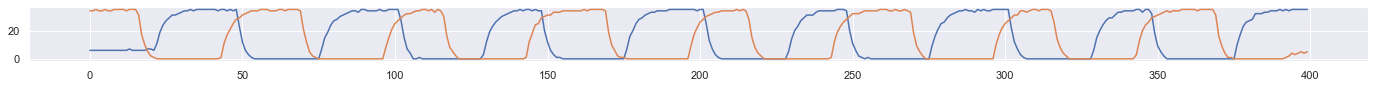

In [247]:
plt.figure(figsize=(24, 1))
plt.plot(light_amp[0,0,0,:])
plt.plot(light_amp[5,0,0,:])

In [172]:
classes

array([[ 8. ,  0. ],
       [ 8. ,  0.5],
       [ 8. ,  1. ],
       [ 8. ,  1.5],
       [ 9. ,  0. ],
       [ 9. ,  0.5],
       [ 9. ,  1. ],
       [ 9. ,  1.5],
       [10. ,  0. ],
       [10. ,  0.5],
       [10. ,  1. ],
       [10. ,  1.5],
       [11. ,  0. ],
       [11. ,  0.5],
       [11. ,  1. ],
       [11. ,  1.5],
       [12. ,  0. ],
       [12. ,  0.5],
       [12. ,  1. ],
       [12. ,  1.5],
       [13. ,  0. ],
       [13. ,  0.5],
       [13. ,  1. ],
       [13. ,  1.5],
       [14. ,  0. ],
       [14. ,  0.5],
       [14. ,  1. ],
       [14. ,  1.5],
       [15. ,  0. ],
       [15. ,  0.5],
       [15. ,  1. ],
       [15. ,  1.5]])

### PSD

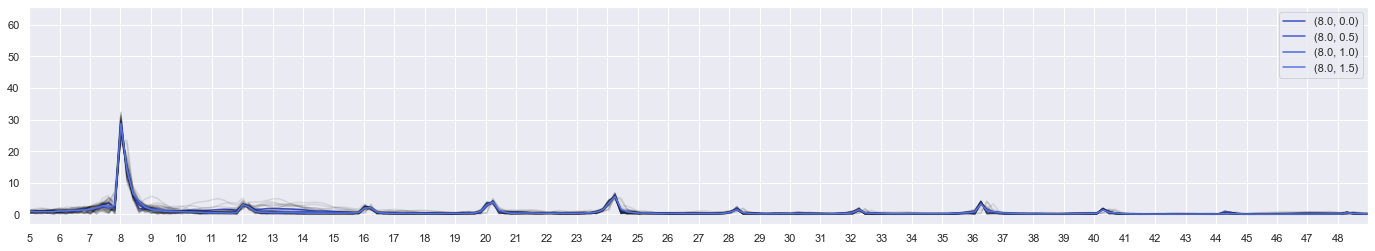

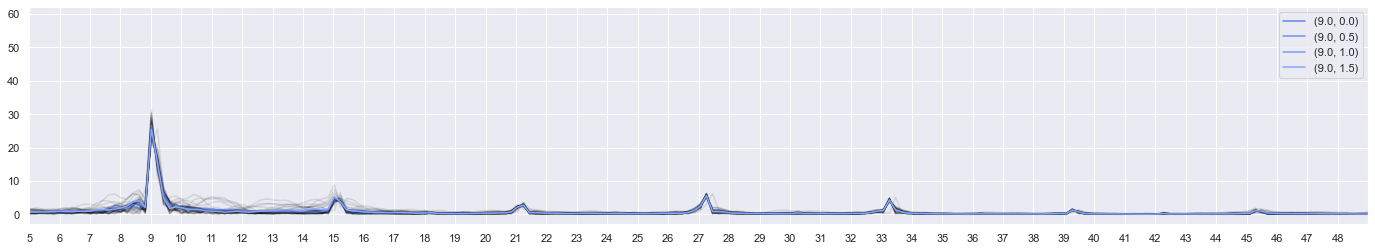

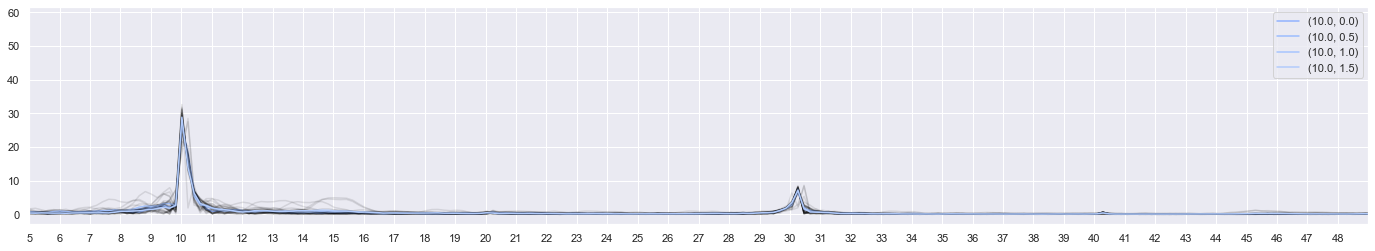

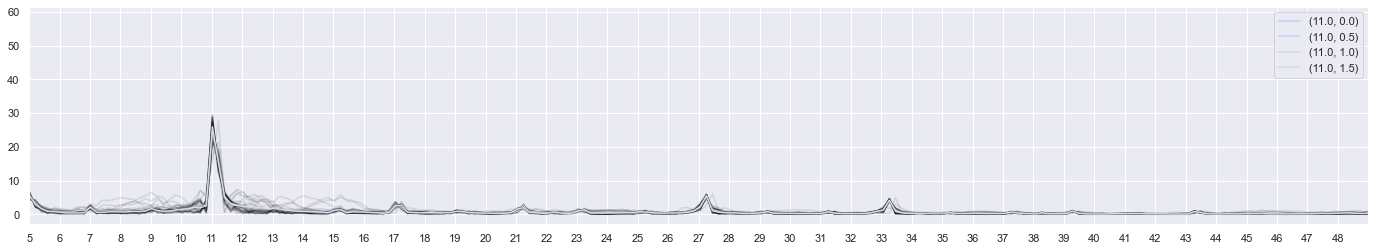

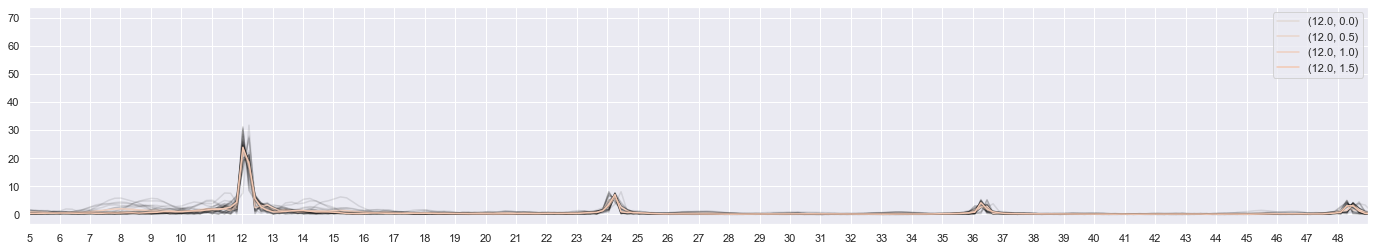

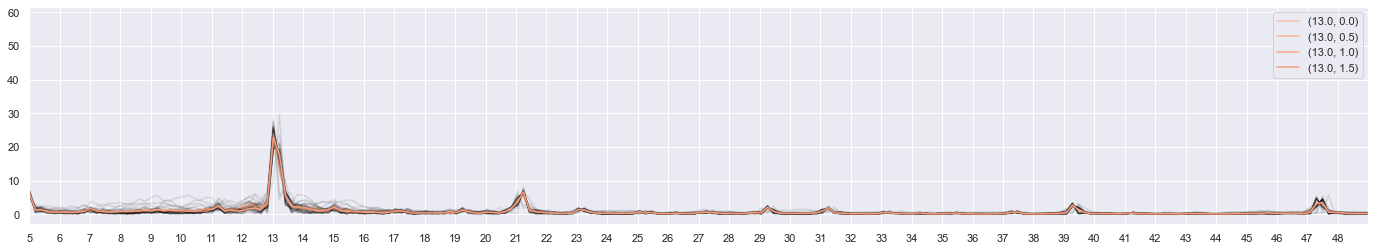

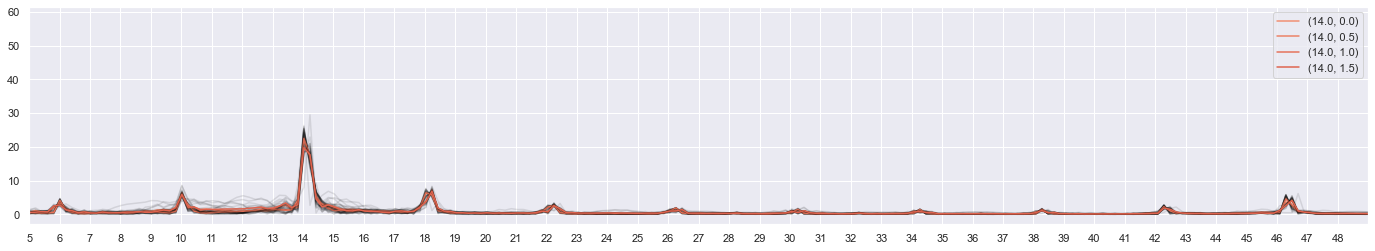

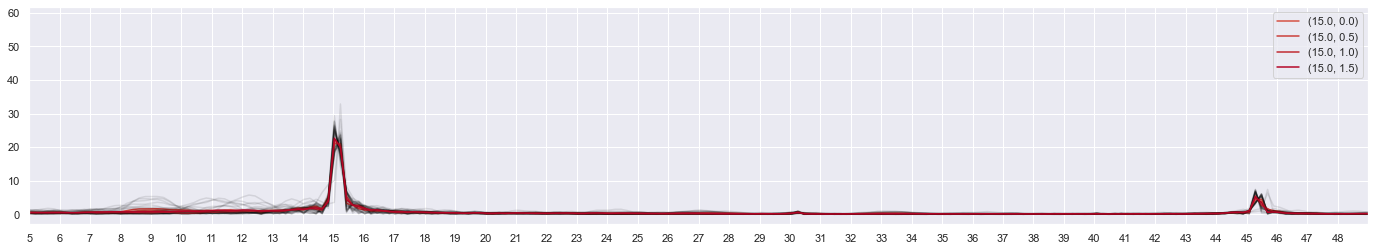

In [126]:
psd = 1/750*np.abs(fft(light_amp))[:,:,:,:(sfreq*5)//2]
freqs = np.linspace(0.0, sfreq / 2, (sfreq*5//2))
colors=cm.coolwarm(np.linspace(0,1,32))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 4))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 0.04)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

### Complex spectra

In [144]:
complex_spectrum = 1/750*fft(light_amp)[:,:,:,:(sfreq*5)//2]

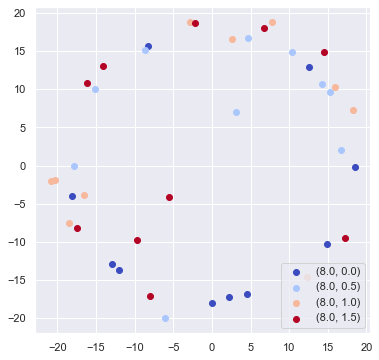

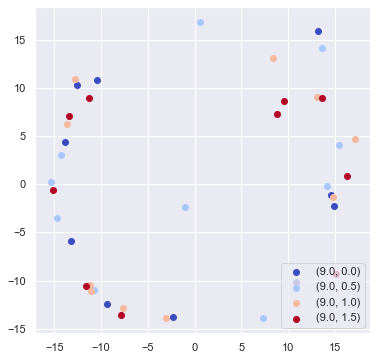

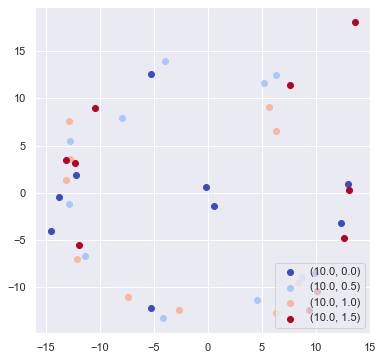

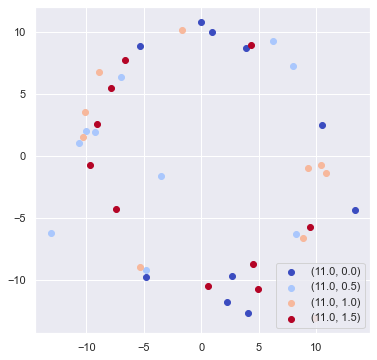

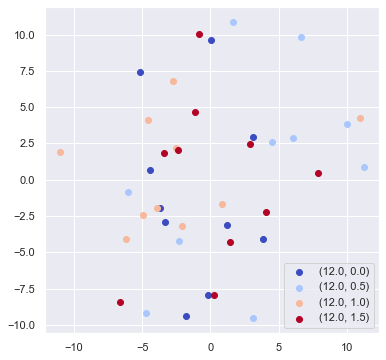

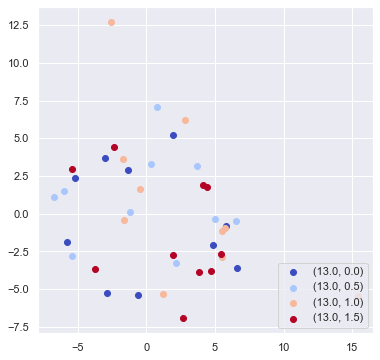

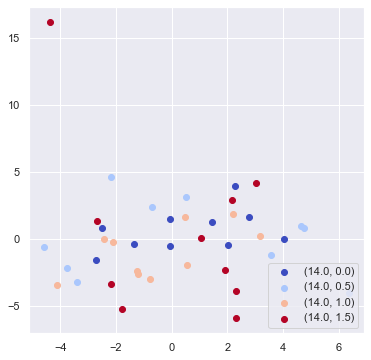

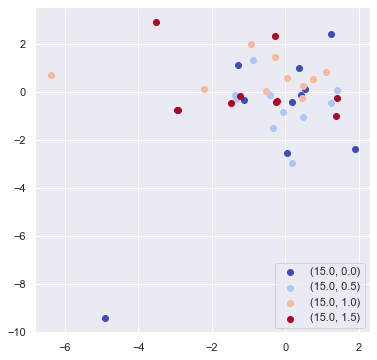

In [145]:
# plot phase-shifted eeg_variates
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, (sfreq*5//2))
for k in range(8):
    k *= 4
    plt.figure(figsize=(6, 6))
    # plt.xlim(-0.07*np.pi, 0.07*np.pi)
    # plt.ylim(-0.07*np.pi, 0.07*np.pi)
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        # for j in range(complex_spectrum.shape[0]):
        #     max_radius = np.abs(complex_spectrum[j,i,0,:]).max()
        #     plt.plot(max_radius*np.cos(np.linspace(0, 2*np.pi, 100)),max_radius*np.sin(np.linspace(0, 2*np.pi, 100)),color=c,alpha=0.1)
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
        # variance_size = np.abs(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()].var(axis=0))
        # plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()].mean(axis=0)),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()].mean(axis=0)),color=c,alpha=0.3,s=(20*variance_size)**2,edgecolor='none')
    # plt.xlim(-max_radius*1.5, max_radius*1.5)
    # plt.ylim(-max_radius*1.5, max_radius*1.5)
    ax.legend(loc='lower right')

In [100]:
num=50000
light_amp['time'][num+296]-light_amp['time'][num]

0.9946239999999875